In [1]:
%cd /Users/gduval/Documents/TOSICA

import TOSICA
import scanpy as sc
import numpy as np
import warnings 
warnings.filterwarnings ("ignore")

/Users/gduval/Documents/TOSICA


Information of GPU

In [ ]:
import torch
print(torch.__version__)
#print(torch.cuda.get_device_capability(device=None),  torch.cuda.get_device_name(device=None))

2.4.0


Reference data

In [3]:
ref_adata = sc.read('../data/ref_sbm/mATLAS_Marrow_facs.h5ad')
ref_adata = ref_adata[:,ref_adata.var_names]
print(ref_adata)
print(ref_adata.obs['free_annotation'].value_counts())

View of AnnData object with n_obs × n_vars = 9734 × 22899
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'n_genes', 'n_counts', 'louvain', 'cluster_names', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_ontology_class_colors', 'leiden', 'louvain', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
free_annotation
Naive B cell                                   1798
Granulocytes                                   1579
HSC enriched fraction                           852
Monocytes, Promonocytes                         797
Pre B                                           576
MPP Fraction C                                  561
MPP Fraction A                                  501
MPP Fraction B                    

Query data

In [ ]:
query_adata = sc.read('../data/raw_sbm/raw_sbm_data_2024_11_15.h5ad')
query_adata = query_adata[:,query_adata.var_names]
print(query_adata)

View of AnnData object with n_obs × n_vars = 22454 × 32285
    obs: '0'
    var: '0'


Training:

In [ ]:
TOSICA.train(ref_adata, gmt_path='mouse_gobp', label_name='free_annotation',epochs=1,project='results/mSBM_test')
!ls ./hGOBP_demo

cpu
Mask loaded!
Model builded!


[train epoch 0] loss: 3.141, acc: 0.029:   0%|          | 17/3618 [01:38<6:42:19,  6.70s/it]

Prediction

In [6]:
model_weight_path = './hGOBP_demo/model-0.pth'
new_adata = TOSICA.pre(query_adata, model_weight_path = model_weight_path,project='hGOBP_demo')

cpu
0
4218


In [7]:
new_adata.write('demo_attn.h5ad')
new_adata

AnnData object with n_obs × n_vars = 4218 × 299
    obs: 'Prediction', 'Probability', 'Celltype'

In [8]:
new_adata.raw = new_adata
sc.pp.normalize_total(new_adata, target_sum=1e4)
sc.pp.log1p(new_adata)
sc.pp.scale(new_adata, max_value=10)
sc.tl.pca(new_adata, svd_solver='arpack')
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(new_adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
col = np.array([
"#98DF8A","#E41A1C" ,"#377EB8", "#4DAF4A" ,"#984EA3" ,"#FF7F00" ,"#FFFF33" ,"#A65628" ,"#F781BF" ,"#999999","#1F77B4","#FF7F0E","#279E68","#FF9896"
]).astype('<U7')

celltype = ("alpha","beta","ductal","acinar","delta","PP","PSC","endothelial","epsilon","mast","macrophage","schwann",'t_cell')
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].astype('category')
new_adata.obs['Prediction'] = new_adata.obs['Prediction'].cat.reorder_categories(list(celltype))
new_adata.uns['Prediction_colors'] = col[1:]

celltype = ("MHC class II","alpha","beta","ductal","acinar","delta","PP","PSC","endothelial","epsilon","mast")
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].astype('category')
new_adata.obs['Celltype'] = new_adata.obs['Celltype'].cat.reorder_categories(list(celltype))
new_adata.uns['Celltype_colors'] = col[:11]

ValueError: items in new_categories are not the same as in old categories

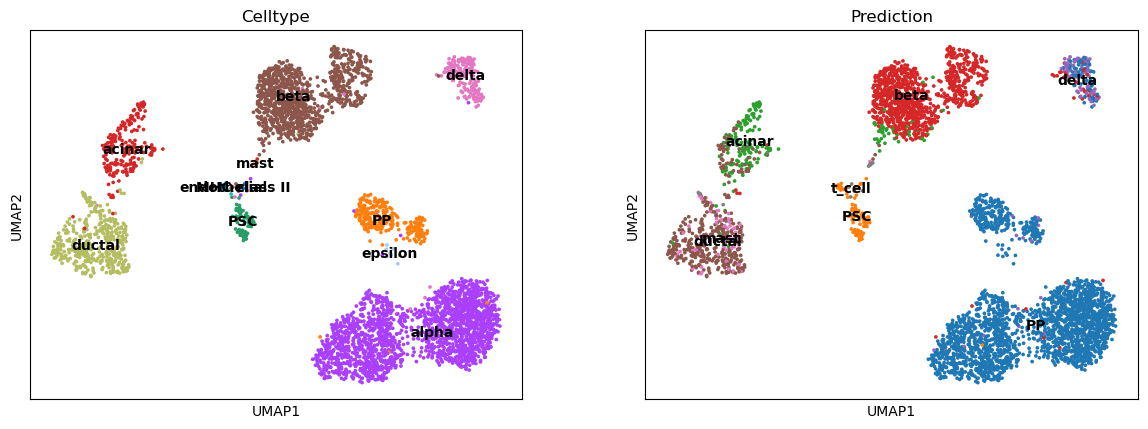

In [10]:
sc.pl.umap(new_adata, color=['Celltype', 'Prediction'],legend_loc='on data')

Training on pre-weights of 'human_gobp' mask:

In [11]:
!cp ./hGOBP_demo/model-0.pth ./pre_weights.pth

In [12]:
TOSICA.train(ref_adata, gmt_path='human_gobp', label_name='Celltype',pre_weights='pre_weights.pth',epochs=1)

cuda:0
Mask loaded!
<All keys matched successfully>
Model builded!


[valid epoch 0] loss: 0.040, acc: 0.992: 100%|██████████| 5096/5096 [00:31<00:00, 162.61it/s]


Training finished!
